<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024Project/blob/Detekcja-sezonowo%C5%9Bci-w-danych/Detekcja_sezonowo%C5%9Bci_w_danych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wczytywanie danych w sparku

Utworzenie środowiska pyspark do obliczeń:

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [3]:
import findspark
findspark.init()

In [116]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql.types import IntegerType, FloatType, StringType, StructType
import IPython
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

Utowrzenie sesji:

In [5]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Połączenie z dyskiem:

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


Wczytanie danych NASA znajdujących się na dysku w sparku:

In [7]:
columns = ['lon', 'lat', 'Date', 'SWdown', 'LWdown', 'SWnet', 'LWnet', 'Qle', 'Qh', 'Qg', 'Qf', 'Snowf', 'Rainf', 'Evap', 'Qs', 'Qsb', 'Qsm', 'AvgSurfT', 'Albedo', 'SWE', 'SnowDepth', 'SnowFrac', 'SoilT_0_10cm', 'SoilT_10_40cm',
           'SoilT_40_100cm', 'SoilT_100_200cm', 'SoilM_0_10cm', 'SoilM_10_40cm', 'SoilM_40_100cm', 'SoilM_100_200cm', 'SoilM_0_100cm', 'SoilM_0_200cm', 'RootMoist', 'SMLiq_0_10cm', 'SMLiq_10_40cm', 'SMLiq_40_100cm', 'SMLiq_100_200cm',
           'SMAvail_0_100cm', 'SMAvail_0_200cm', 'PotEvap', 'ECanop', 'TVeg', 'ESoil', 'SubSnow', 'CanopInt', 'ACond', 'CCond', 'RCS', 'RCT', 'RCQ', 'RCSOL', 'RSmin','RSMacr', 'LAI', 'GVEG', 'Streamflow']

# Utworzenie schematu określającego typ zmiennych
schema = StructType()
for i in columns:
  if i == "Date":
    schema = schema.add(i, StringType(), True)
  else:
    schema = schema.add(i, FloatType(), True)

In [8]:
# Wczytanie zbioru Nasa w sparku
nasa = spark.read.format('csv').option("header", True).schema(schema).load('/content/drive/MyDrive/BigMess/NASA/NASA.csv')

Zanim zaczniemy pisać kwerendy należy jeszcze dodać nasz DataFrame (df) do "przestrzeni nazw tabel" Sparka:

In [9]:
nasa.createOrReplaceTempView("nasa")

Rozdzielenie kolumny "Date" na kolumny "Year" oraz "Month"

In [10]:
nasa_ym = spark.sql("""
          SELECT
          CAST(SUBSTRING(CAST(Date AS STRING), 1, 4) AS INT) AS Year,
          CAST(SUBSTRING(CAST(Date AS STRING), 5, 2) AS INT) AS Month,
          n.*
          FROM nasa n
          """)

In [11]:
nasa_ym = nasa_ym.drop("Date")
nasa_ym.createOrReplaceTempView("nasa_ym")

# Analiza szergów czasowych - tylko wybrane kolumny z pliku "research.md"

In [12]:
# Wyzanczenie unikatowych par współrzednych ze zbioru Nasa i zapisanie w Pandas
%%time
distinct_wsp = spark.sql("""
                          SELECT DISTINCT lon, lat FROM nasa
                          """).toPandas()

CPU times: user 1.67 s, sys: 192 ms, total: 1.87 s
Wall time: 4min 8s


In [13]:
distinct_wsp.shape

(76360, 2)

In [14]:
def extract_time_series_from_dataframe(sdf: SparkDataFrame, lon: float, lat: float) -> pd.DataFrame:
  """
  Funkcja przekształcająca zadany SparkDataFrame w szereg czasowy dla zadanych współrzednych lon, lat.
  Parametry:
  - df (SparkDataFrame): ramka danych w Sparku zawierająca następujace kolumny: lon, lat, Date (pomiar ustawiony na pierwszy dzien miesiąca), atrybuty
  - lon (float): długość geograficzna
  - lat (float): szerokość geograficzna
  """
  # ograniczenie zbioru do konkretnej pary współrzędnych
  time_series = sdf.filter((sdf['lon'] == lon) & (sdf['lat'] == lat))
  # Przejście na pandas
  time_series_Pandas = time_series.toPandas()
  # Ustawienie 'date' jako indeksu
  time_series_Pandas.set_index('Date', inplace=True)
  return time_series_Pandas

In [15]:
def plot_time_series(df: pd.DataFrame, attribute: str) -> None:
  """
  Funkcja generująca wykres w czasie dla zadanego atrybutu.
  Parametry:
  - df (DataFrame): szereg czasowy; Pandas DataFrame
  - attribute (str): atrybut, dla którego chcemy zrobić wykres w czasie
  """
  assert attribute in df.columns, f"The attribute '{attribute}' is not a column in the DataFrame."
  # Obliczanie 12-miesięcznej średniej kroczącej
  df['12m_MA'] = df[attribute].rolling(window=12).mean()
  # Tworzenie wykresu
  plt.figure(figsize=(11,6))
  gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
  xmin, xmax = df.index.min() - pd.DateOffset(years=1) , df.index.max() + pd.DateOffset(years=1)

  ax1 = plt.subplot(gs[0])
  ax1.plot(df.index, df[attribute])
  ax1.plot(df.index, df['12m_MA'], label='12-miesięczna średnia krocząca', color='red')
  ax1.set_title(f"Wykres Szeregu Czasowego dla lon = {df['lon'].unique()}, lat = {df['lat'].unique()}")
  ax1.legend(loc='upper left')
  ax1.set_ylabel(f"Wartość {attribute}")
  ax1.set_xlim(xmin, xmax)
  ax1.grid(True)

  ax2 = plt.subplot(gs[1])
  ax2.plot(df.index, df['12m_MA'], label='12-miesięczna średnia krocząca', color='red')
  ax2.set_xlabel('Data')
  ax2.grid(True)
  ax2.set_xlim(xmin, xmax)

  plt.tight_layout()
  plt.show()

In [27]:
# Funkcja do sprawdzania stacjonarności szeregu czasowego
def check_stationarity(series):

    # Augmented Dickey-Fuller unit root test
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [16]:
print("Lon Range:", distinct_wsp['lon'].min(), distinct_wsp['lon'].max())
print("Lat Range:", distinct_wsp['lat'].min(), distinct_wsp['lat'].max())

Lon Range: -124.9375 -67.0625
Lat Range: 25.0625 52.9375


Do przeprowadzenia analizy weźmy trzy lokalizacje:


*   obszar niepustynny,
*   obszar przejściowy,
*   obszar pustynny.



In [17]:
# Obszar niepustynny
src = "https://www.globalforestwatch.org/map/country/USA/?map=eyJjZW50ZXIiOnsibGF0IjozOS45Mzc1LCJsbmciOi0xMjAuMTg3NDk5OTk5OTk5OTl9LCJ6b29tIjo5LjI1NDQyNDE0NjA1NDM4OCwiY2FuQm91bmQiOmZhbHNlLCJkYXRhc2V0cyI6W3siZGF0YXNldCI6InBvbGl0aWNhbC1ib3VuZGFyaWVzIiwibGF5ZXJzIjpbImRpc3B1dGVkLXBvbGl0aWNhbC1ib3VuZGFyaWVzIiwicG9saXRpY2FsLWJvdW5kYXJpZXMiXSwib3BhY2l0eSI6MSwidmlzaWJpbGl0eSI6dHJ1ZX0seyJkYXRhc2V0IjoidHJlZS1jb3Zlci1nYWluIiwibGF5ZXJzIjpbInRyZWUtY292ZXItZ2Fpbi0yMDAxLTIwMjAiXSwib3BhY2l0eSI6MSwidmlzaWJpbGl0eSI6dHJ1ZX0seyJkYXRhc2V0IjoidHJlZS1jb3Zlci1sb3NzIiwibGF5ZXJzIjpbInRyZWUtY292ZXItbG9zcyJdLCJvcGFjaXR5IjoxLCJ2aXNpYmlsaXR5Ijp0cnVlLCJ0aW1lbGluZVBhcmFtcyI6eyJzdGFydERhdGUiOiIyMDAxLTAxLTAxIiwiZW5kRGF0ZSI6IjIwMjItMTItMzEiLCJ0cmltRW5kRGF0ZSI6IjIwMjItMTItMzEifX0seyJkYXRhc2V0IjoidHJlZS1jb3ZlciIsImxheWVycyI6WyJ0cmVlLWNvdmVyLTIwMTAiXSwib3BhY2l0eSI6MSwidmlzaWJpbGl0eSI6dHJ1ZX1dfQ%3D%3D&mapMenu=eyJzZWFyY2hUeXBlIjoiZGVjaW1hbHMifQ%3D%3D&mapPrompts=eyJvcGVuIjp0cnVlLCJzdGVwc0tleSI6InJlY2VudEltYWdlcnkifQ%3D%3D"
IPython.display.IFrame(src, width=900, height=500)

In [18]:
# Wybranie najlepszego punktu w danych do punktu (39.9268, -120.1052)
distinct_wsp[(distinct_wsp['lon']<=-120) & (distinct_wsp['lon']>=-120.2) & (distinct_wsp['lat']<=40) & (distinct_wsp['lat']>=39.8)]

,lon,lat
1698,-120.0625,39.8125
5888,-120.1875,39.9375
31067,-120.0625,39.9375
35601,-120.1875,39.8125


Weźmy punkt nr 5888 ponieważ można na nim zaobserwować zmianę ilości drzew w ostatnich latach.

In [19]:
# Obszar przejściowy
src = "https://www.globalforestwatch.org/map/country/USA/?map=eyJjZW50ZXIiOnsibGF0IjozOS44NDA1MDE5NTc5NDMzMSwibG5nIjotMTE5Ljc1ODA0NTUwOTkyMDczfSwiem9vbSI6OS4wMDMyMTc1NjA3Njc2MDIsImNhbkJvdW5kIjpmYWxzZSwiZGF0YXNldHMiOlt7ImRhdGFzZXQiOiJwb2xpdGljYWwtYm91bmRhcmllcyIsImxheWVycyI6WyJkaXNwdXRlZC1wb2xpdGljYWwtYm91bmRhcmllcyIsInBvbGl0aWNhbC1ib3VuZGFyaWVzIl0sIm9wYWNpdHkiOjEsInZpc2liaWxpdHkiOnRydWV9LHsiZGF0YXNldCI6InRyZWUtY292ZXItZ2FpbiIsImxheWVycyI6WyJ0cmVlLWNvdmVyLWdhaW4tMjAwMS0yMDIwIl0sIm9wYWNpdHkiOjEsInZpc2liaWxpdHkiOnRydWV9LHsiZGF0YXNldCI6InRyZWUtY292ZXItbG9zcyIsImxheWVycyI6WyJ0cmVlLWNvdmVyLWxvc3MiXSwib3BhY2l0eSI6MSwidmlzaWJpbGl0eSI6dHJ1ZSwidGltZWxpbmVQYXJhbXMiOnsic3RhcnREYXRlIjoiMjAwMS0wMS0wMSIsImVuZERhdGUiOiIyMDIyLTEyLTMxIiwidHJpbUVuZERhdGUiOiIyMDIyLTEyLTMxIn19LHsiZGF0YXNldCI6InRyZWUtY292ZXIiLCJsYXllcnMiOlsidHJlZS1jb3Zlci0yMDEwIl0sIm9wYWNpdHkiOjEsInZpc2liaWxpdHkiOnRydWV9XX0%3D&mapMenu=eyJzZWFyY2hUeXBlIjoiZGVjaW1hbHMiLCJzZWFyY2giOiJDZW50cmFsIEJhc2luIGFuZCBSYW5nZSJ9&mapPrompts=eyJvcGVuIjp0cnVlLCJzdGVwc0tleSI6InJlY2VudEltYWdlcnkifQ%3D%3D"
IPython.display.IFrame(src, width=900, height=500)

In [20]:
# Wybranie najlepszego punktu w danych do punktu (39.8405, -119,75805)
distinct_wsp[(distinct_wsp['lon']<=-119.6) & (distinct_wsp['lon']>=-119.8) & (distinct_wsp['lat']<=40) & (distinct_wsp['lat']>=39.7)]

,lon,lat
57645,-119.6875,39.9375
76158,-119.6875,39.8125


Weźmy punkt nr 76158.

In [21]:
# Obszar pustynny
src = "https://www.globalforestwatch.org/map/country/USA/?map=eyJjZW50ZXIiOnsibGF0IjozOS43NzcwNzMwNzg3MDQ1NTQsImxuZyI6LTExOC41NDA0NTc4NDkzOTQ5M30sInpvb20iOjkuNzUzNjE5NzU1ODYzMTEsImNhbkJvdW5kIjpmYWxzZSwiZGF0YXNldHMiOlt7ImRhdGFzZXQiOiJwb2xpdGljYWwtYm91bmRhcmllcyIsImxheWVycyI6WyJkaXNwdXRlZC1wb2xpdGljYWwtYm91bmRhcmllcyIsInBvbGl0aWNhbC1ib3VuZGFyaWVzIl0sIm9wYWNpdHkiOjEsInZpc2liaWxpdHkiOnRydWV9LHsiZGF0YXNldCI6InRyZWUtY292ZXItZ2FpbiIsImxheWVycyI6WyJ0cmVlLWNvdmVyLWdhaW4tMjAwMS0yMDIwIl0sIm9wYWNpdHkiOjEsInZpc2liaWxpdHkiOnRydWV9LHsiZGF0YXNldCI6InRyZWUtY292ZXItbG9zcyIsImxheWVycyI6WyJ0cmVlLWNvdmVyLWxvc3MiXSwib3BhY2l0eSI6MSwidmlzaWJpbGl0eSI6dHJ1ZSwidGltZWxpbmVQYXJhbXMiOnsic3RhcnREYXRlIjoiMjAwMS0wMS0wMSIsImVuZERhdGUiOiIyMDIyLTEyLTMxIiwidHJpbUVuZERhdGUiOiIyMDIyLTEyLTMxIn19LHsiZGF0YXNldCI6InRyZWUtY292ZXIiLCJsYXllcnMiOlsidHJlZS1jb3Zlci0yMDEwIl0sIm9wYWNpdHkiOjEsInZpc2liaWxpdHkiOnRydWV9XX0%3D&mapMenu=eyJzZWFyY2hUeXBlIjoiZGVjaW1hbHMiLCJzZWFyY2giOiJDZW50cmFsIEJhc2luIGFuZCBSYW5nZSJ9&mapPrompts=eyJvcGVuIjp0cnVlLCJzdGVwc0tleSI6InJlY2VudEltYWdlcnkifQ%3D%3D"
IPython.display.IFrame(src, width=900, height=500)

## **Rainf** (wskaźnik opadów deszczu)

In [29]:
#Pomiaru zawsze na 1 dzień miesiąca
Rainf_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, Rainf
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

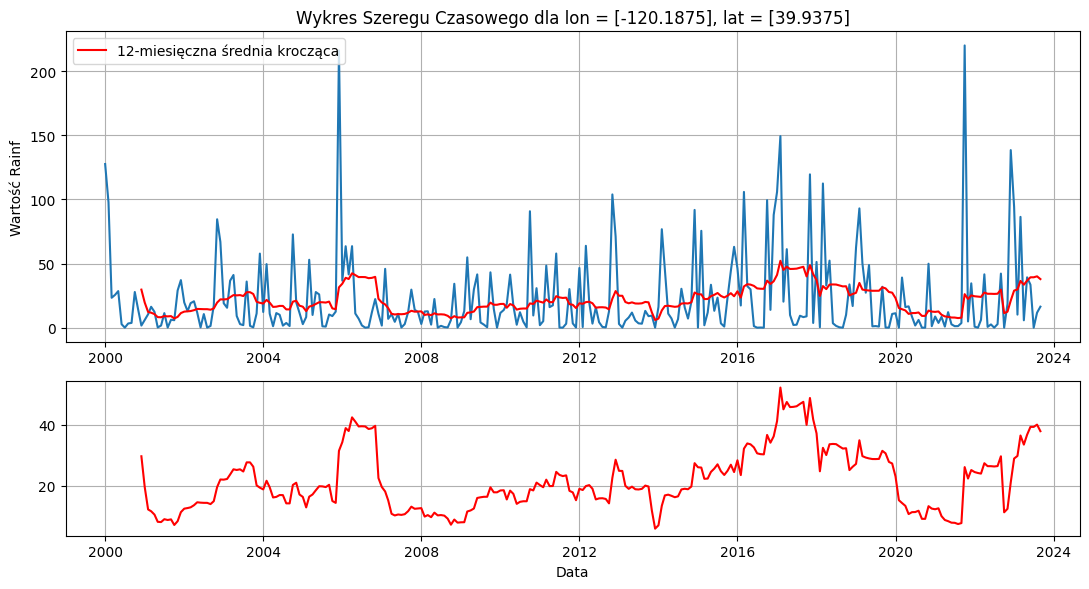

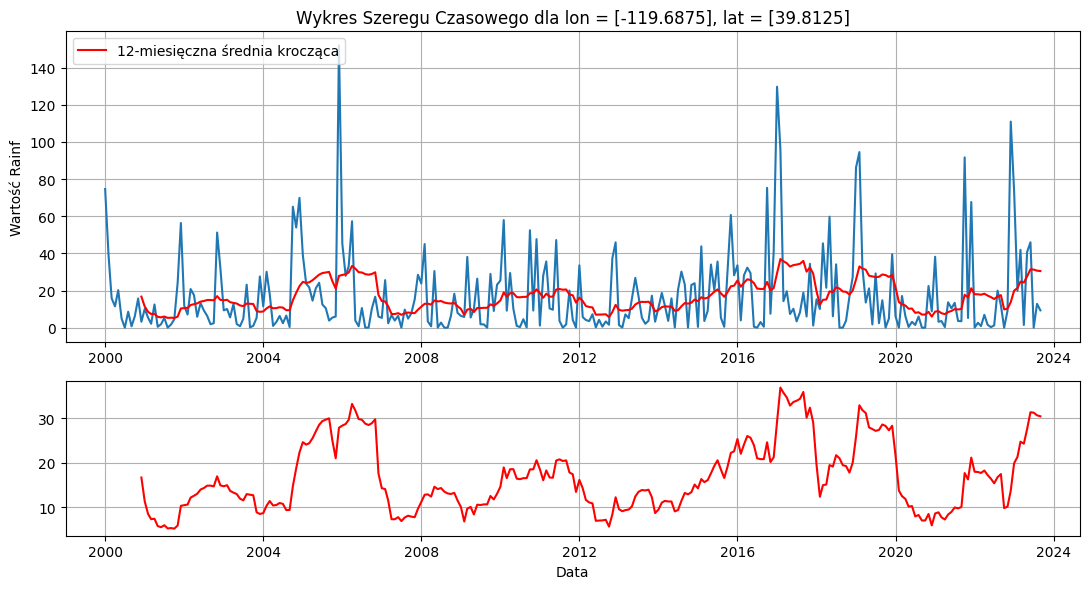

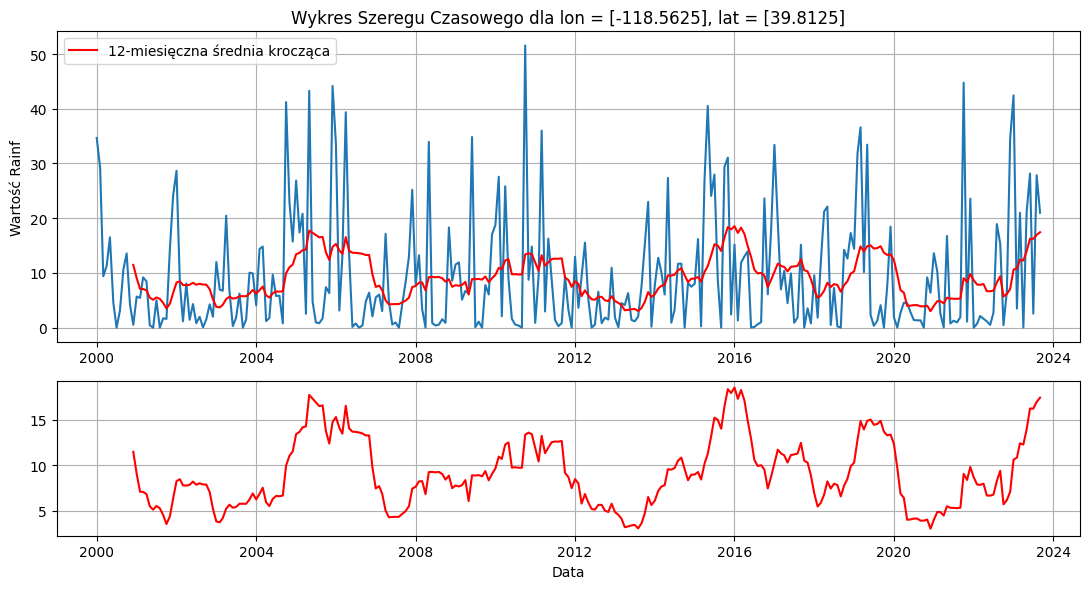

In [31]:
Rainf_time_series_nie_pustynia = extract_time_series_from_dataframe(Rainf_SparkDataFrame, -120.1875, 39.9375)
Rainf_time_series_przejsciowe = extract_time_series_from_dataframe(Rainf_SparkDataFrame, -119.6875, 39.8125)
Rainf_time_series_pustynia = extract_time_series_from_dataframe(Rainf_SparkDataFrame, -118.5625, 39.8125)
plot_time_series(Rainf_time_series_nie_pustynia, 'Rainf')
plot_time_series(Rainf_time_series_przejsciowe, 'Rainf')
plot_time_series(Rainf_time_series_pustynia, 'Rainf')

In [32]:
check_stationarity(Rainf_time_series_pustynia['Rainf'])

ADF Statistic: -13.932434
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Stationary


In [33]:
check_stationarity(Rainf_time_series_przejsciowe['Rainf'])

ADF Statistic: -13.025105
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Stationary


In [34]:
check_stationarity(Rainf_time_series_nie_pustynia['Rainf'])

ADF Statistic: -2.855003
p-value: 0.050836
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Non-stationary


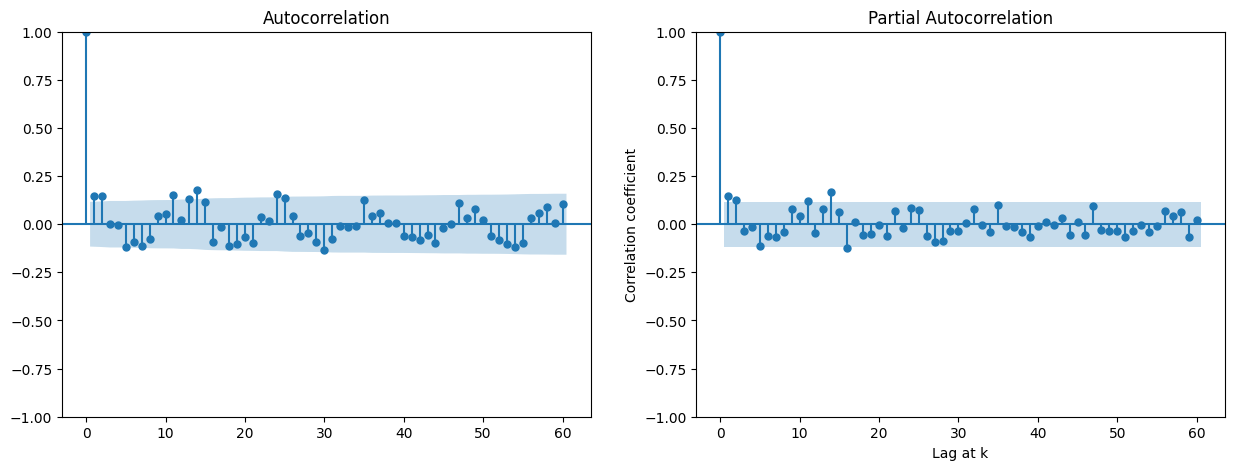

In [118]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
tsaplots.plot_acf(Rainf_time_series_nie_pustynia['Rainf'], lags=60, ax=ax[0])
tsaplots.plot_pacf(Rainf_time_series_nie_pustynia['Rainf'], lags=60, ax=ax[1])
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

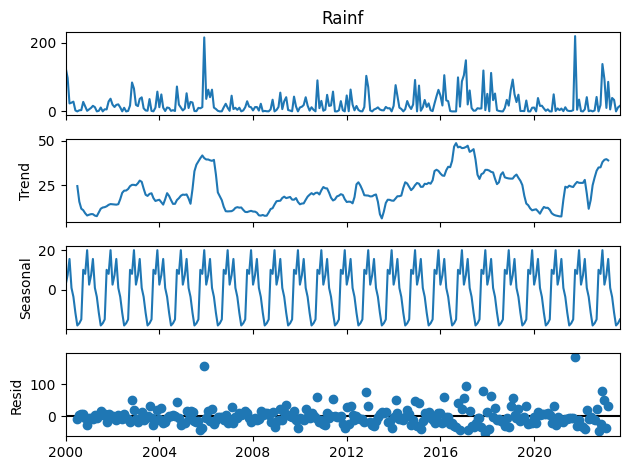

In [119]:
results = seasonal_decompose(Rainf_time_series_nie_pustynia['Rainf'], model="additive", period=12)
results.plot()
plt.show()

## **Evap** (wskaźnik całkowitej ewapotranspiracji)

In [36]:
#Pomiaru zawsze na 1 dzień miesiąca
Evap_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, Evap
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

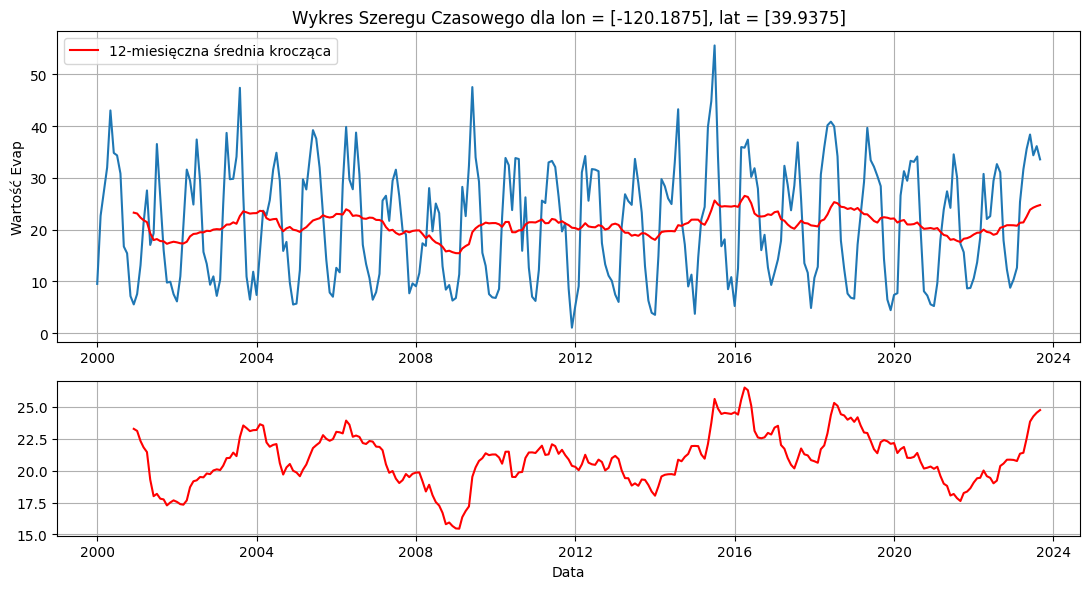

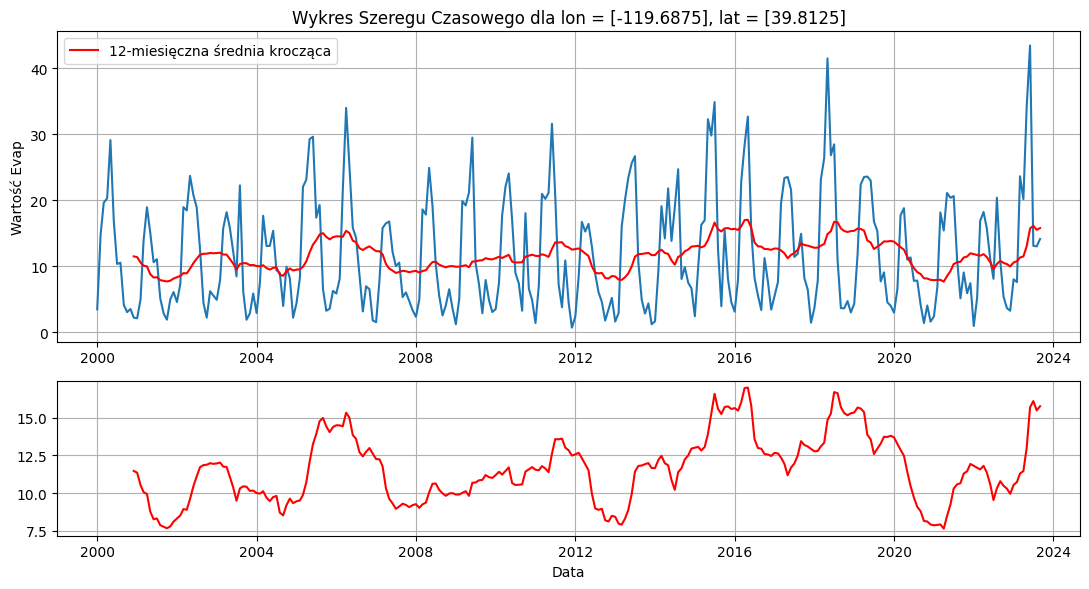

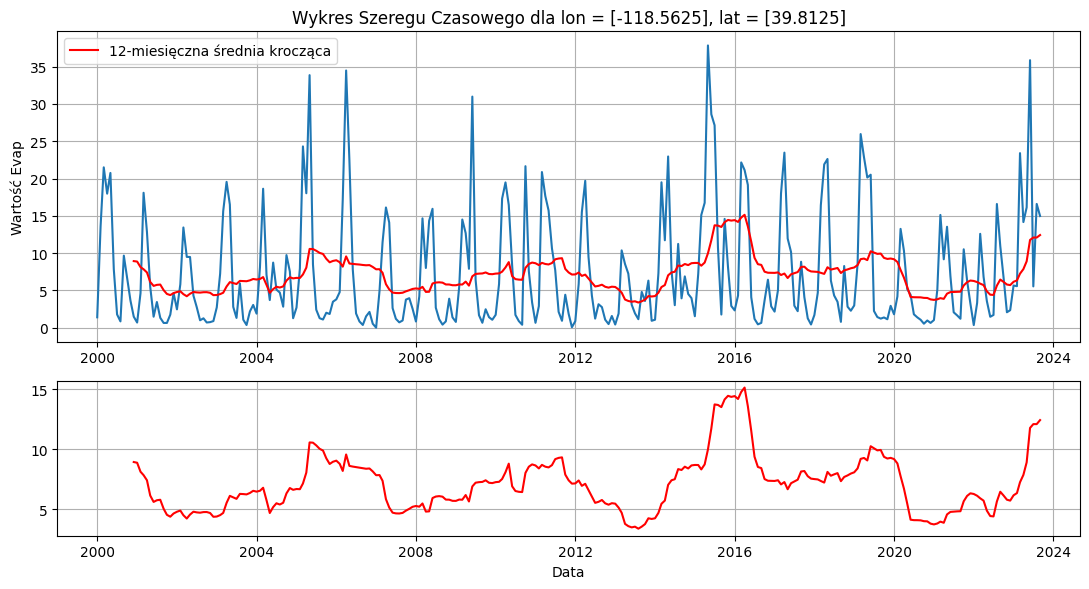

In [37]:
Evap_time_series_nie_pustynia = extract_time_series_from_dataframe(Evap_SparkDataFrame, -120.1875, 39.9375)
Evap_time_series_przejsciowe = extract_time_series_from_dataframe(Evap_SparkDataFrame, -119.6875, 39.8125)
Evap_time_series_pustynia = extract_time_series_from_dataframe(Evap_SparkDataFrame, -118.5625, 39.8125)
plot_time_series(Evap_time_series_nie_pustynia, 'Evap')
plot_time_series(Evap_time_series_przejsciowe, 'Evap')
plot_time_series(Evap_time_series_pustynia, 'Evap')

In [38]:
check_stationarity(Evap_time_series_pustynia['Evap'])

ADF Statistic: -2.459303
p-value: 0.125693
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Non-stationary


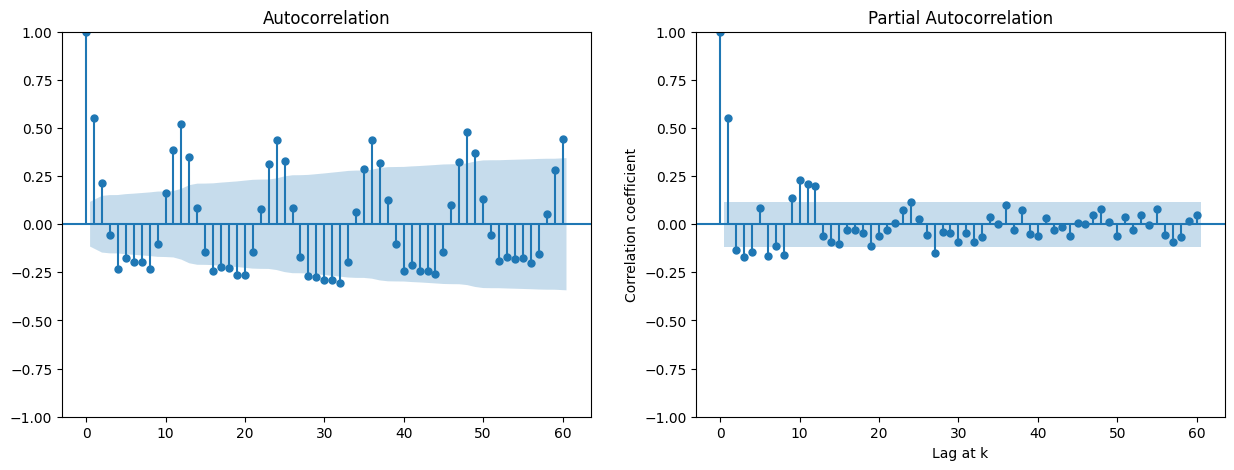

In [117]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
tsaplots.plot_acf(Evap_time_series_pustynia['Evap'], lags=60, ax=ax[0])
tsaplots.plot_pacf(Evap_time_series_pustynia['Evap'], lags=60, ax=ax[1])
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

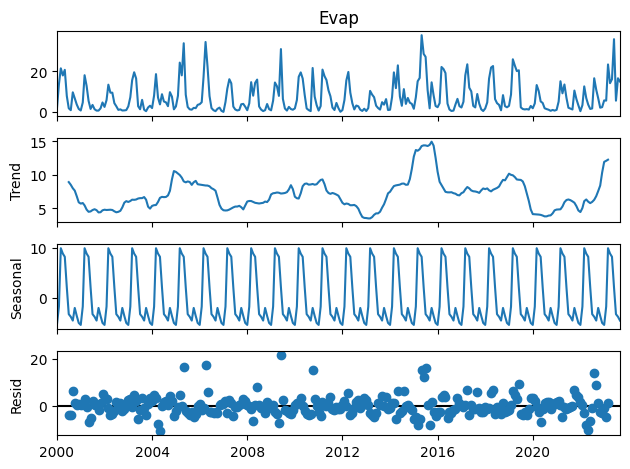

In [85]:
results = seasonal_decompose(Evap_time_series_pustynia['Evap'], model="additive", period=12)
results.plot()
plt.show()

In [39]:
check_stationarity(Evap_time_series_przejsciowe['Evap'])

ADF Statistic: -2.758408
p-value: 0.064465
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Non-stationary


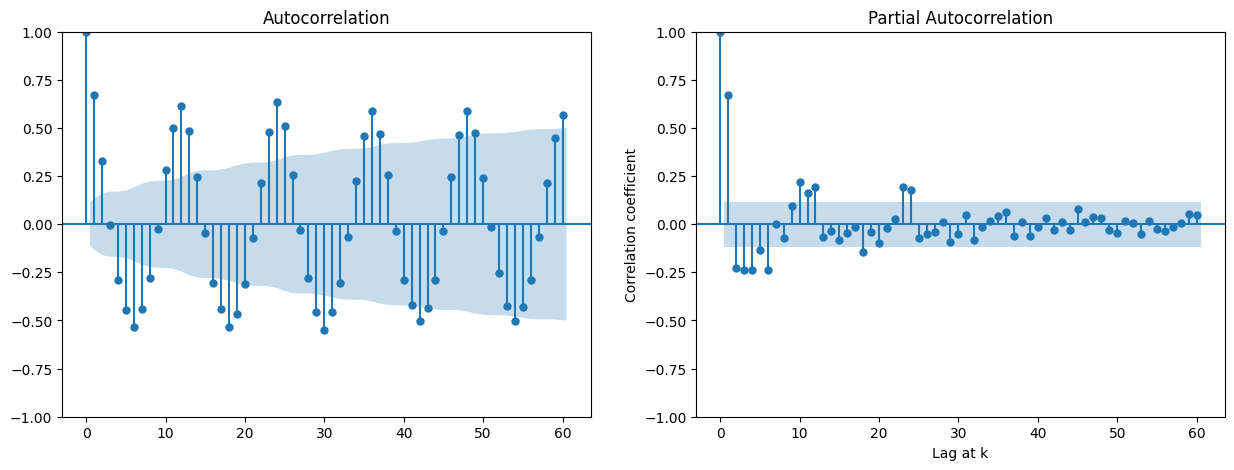

In [115]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
tsaplots.plot_acf(Evap_time_series_przejsciowe['Evap'], lags=60, ax=ax[0])
tsaplots.plot_pacf(Evap_time_series_przejsciowe['Evap'], lags=60, ax=ax[1])
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

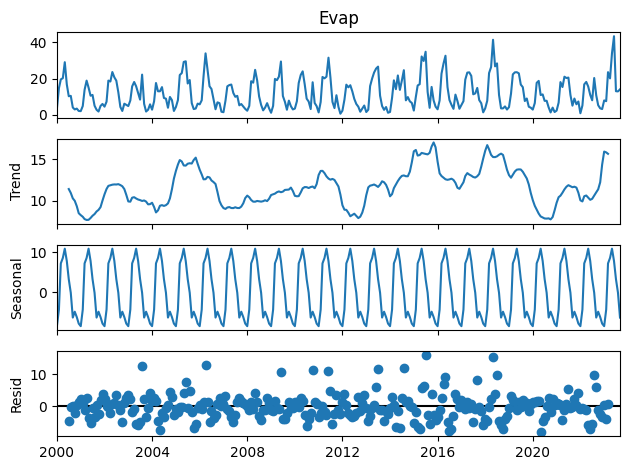

In [88]:
results = seasonal_decompose(Evap_time_series_przejsciowe['Evap'], model="additive", period=12)
results.plot()
plt.show()

In [40]:
check_stationarity(Evap_time_series_nie_pustynia['Evap'])

ADF Statistic: -3.056556
p-value: 0.029940
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Stationary


## **AvgSurfT** (wskaźnik średniej temperatury powierzchni ziemi)

In [41]:
#Pomiaru zawsze na 1 dzień miesiąca
AvgSurfT_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, AvgSurfT
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

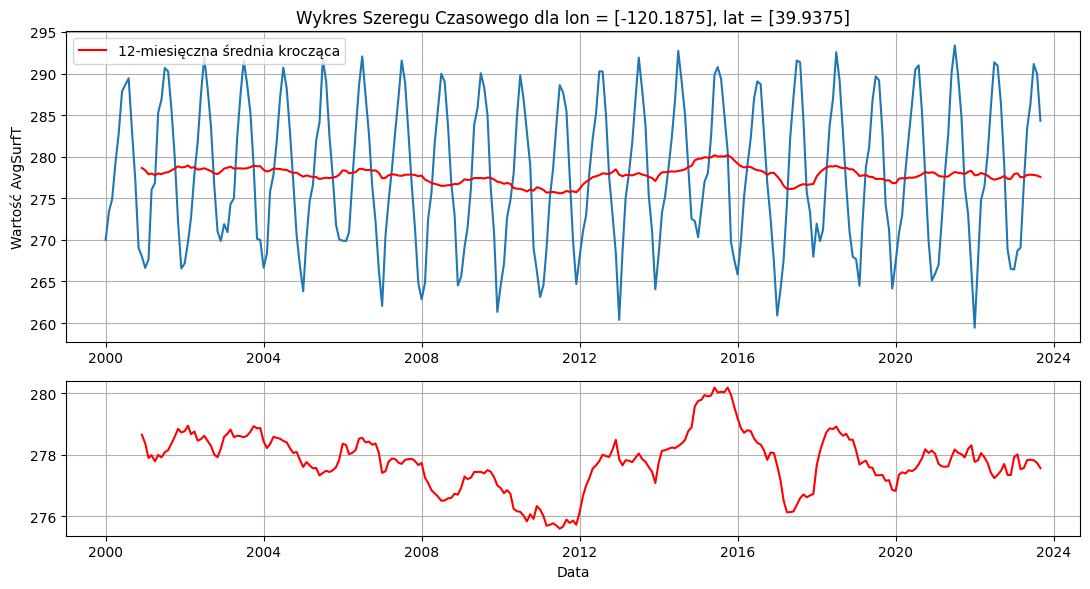

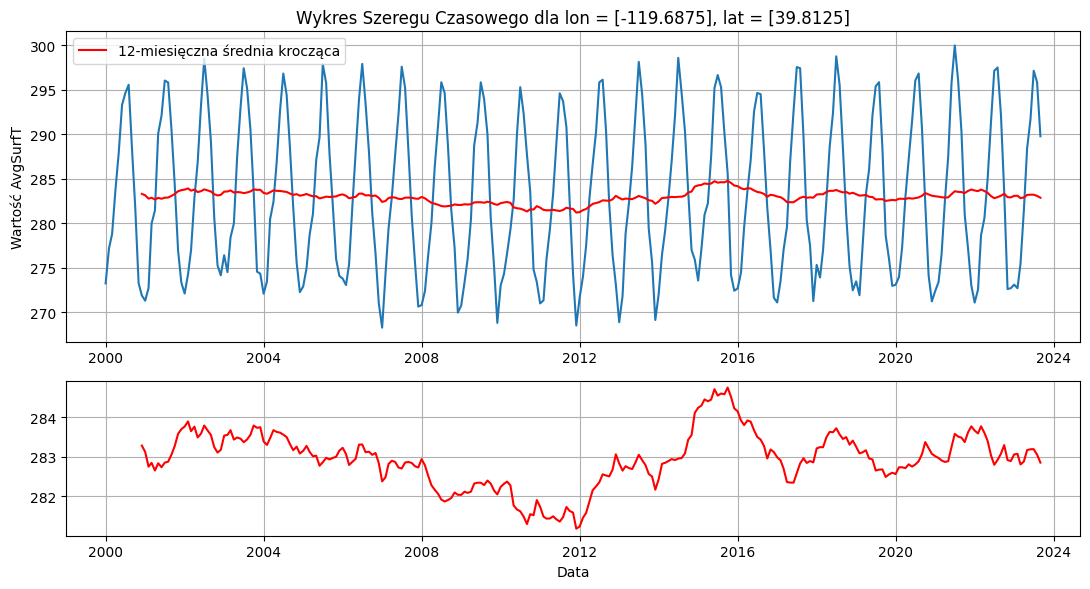

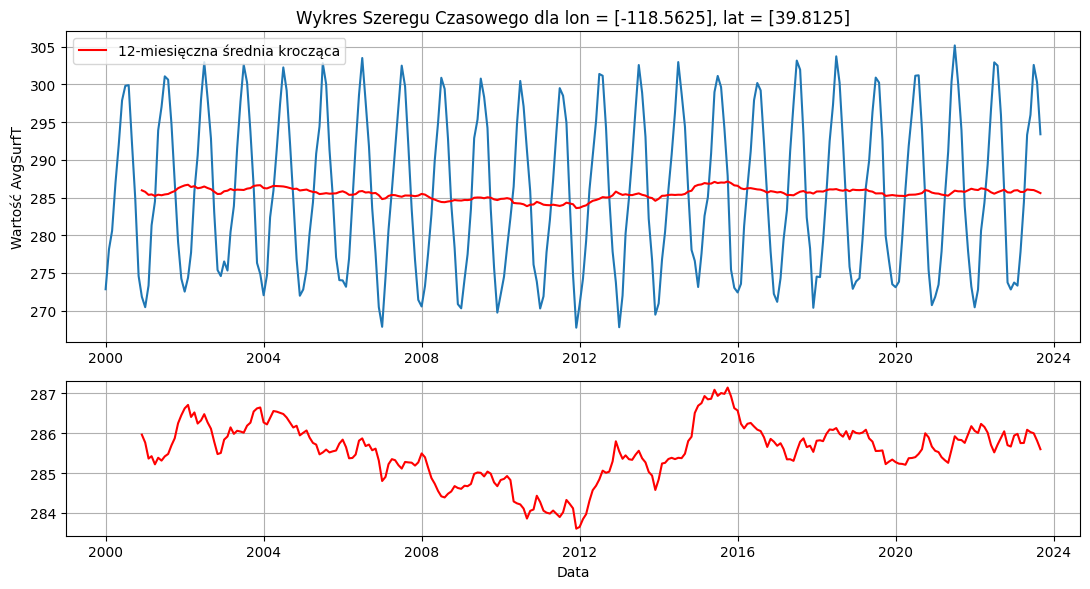

In [42]:
AvgSurfT_time_series_nie_pustynia = extract_time_series_from_dataframe(AvgSurfT_SparkDataFrame, -120.1875, 39.9375)
AvgSurfT_time_series_przejsciowe = extract_time_series_from_dataframe(AvgSurfT_SparkDataFrame, -119.6875, 39.8125)
AvgSurfT_time_series_pustynia = extract_time_series_from_dataframe(AvgSurfT_SparkDataFrame, -118.5625, 39.8125)
plot_time_series(AvgSurfT_time_series_nie_pustynia, 'AvgSurfT')
plot_time_series(AvgSurfT_time_series_przejsciowe, 'AvgSurfT')
plot_time_series(AvgSurfT_time_series_pustynia, 'AvgSurfT')

In [43]:
check_stationarity(AvgSurfT_time_series_pustynia['AvgSurfT'])

ADF Statistic: -2.238473
p-value: 0.192579
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Non-stationary


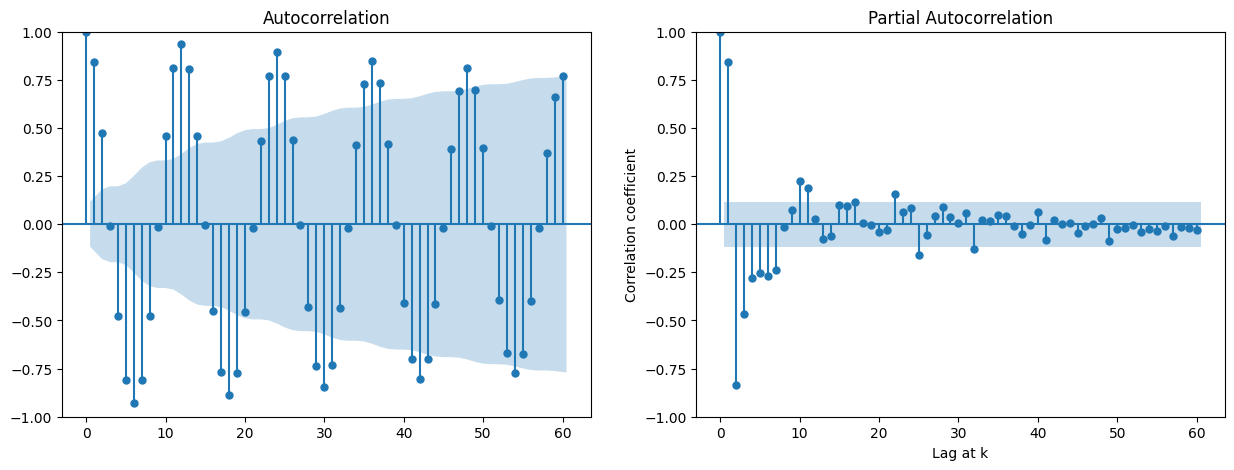

In [120]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
tsaplots.plot_acf(AvgSurfT_time_series_pustynia['AvgSurfT'], lags=60, ax=ax[0])
tsaplots.plot_pacf(AvgSurfT_time_series_pustynia['AvgSurfT'], lags=60, ax=ax[1])
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

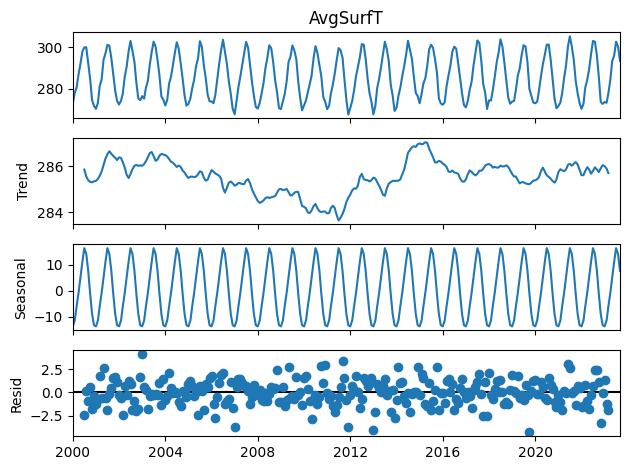

In [121]:
results = seasonal_decompose(AvgSurfT_time_series_pustynia['AvgSurfT'], model="additive", period=12)
results.plot()
plt.show()

In [44]:
check_stationarity(AvgSurfT_time_series_przejsciowe['AvgSurfT'])

ADF Statistic: -2.234829
p-value: 0.193848
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Non-stationary


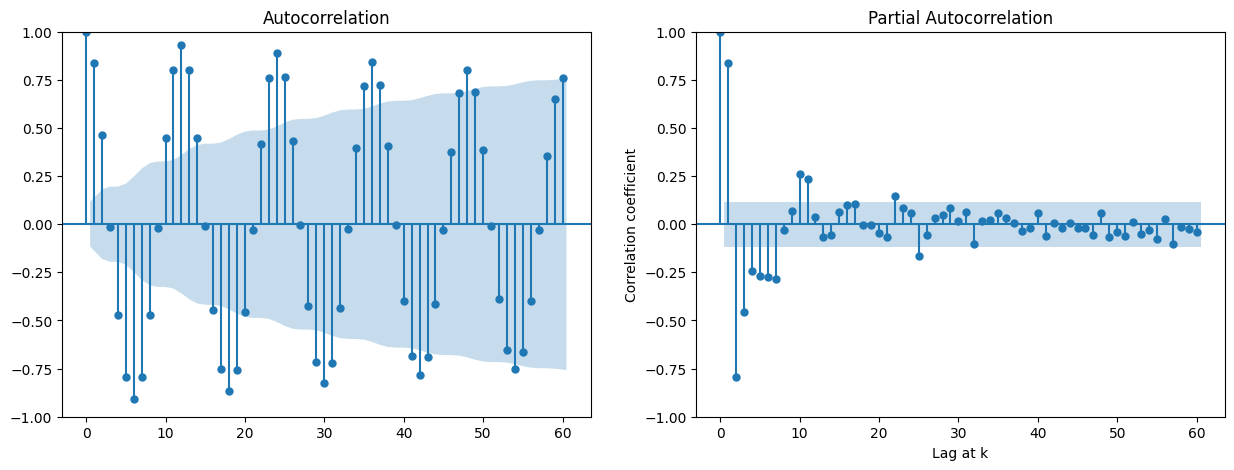

In [122]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
tsaplots.plot_acf(AvgSurfT_time_series_przejsciowe['AvgSurfT'], lags=60, ax=ax[0])
tsaplots.plot_pacf(AvgSurfT_time_series_przejsciowe['AvgSurfT'], lags=60, ax=ax[1])
plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

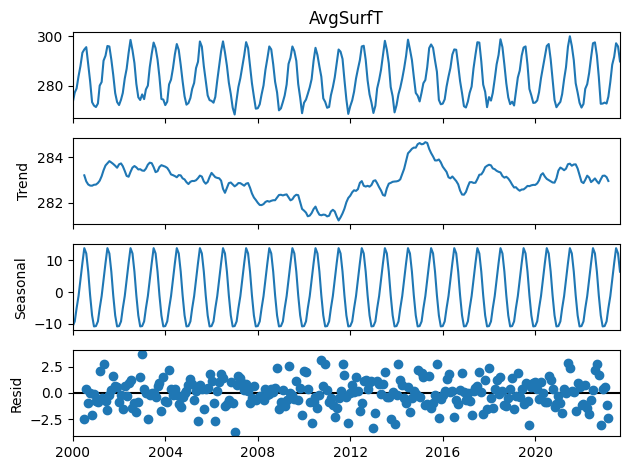

In [123]:
results = seasonal_decompose(AvgSurfT_time_series_przejsciowe['AvgSurfT'], model="additive", period=12)
results.plot()
plt.show()

In [124]:
check_stationarity(AvgSurfT_time_series_nie_pustynia['AvgSurfT'])

ADF Statistic: -2.981461
p-value: 0.036662
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Stationary


## **Albedo** (wskaźnik albedo)

In [46]:
#Pomiaru zawsze na 1 dzień miesiąca
Albedo_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, Albedo
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

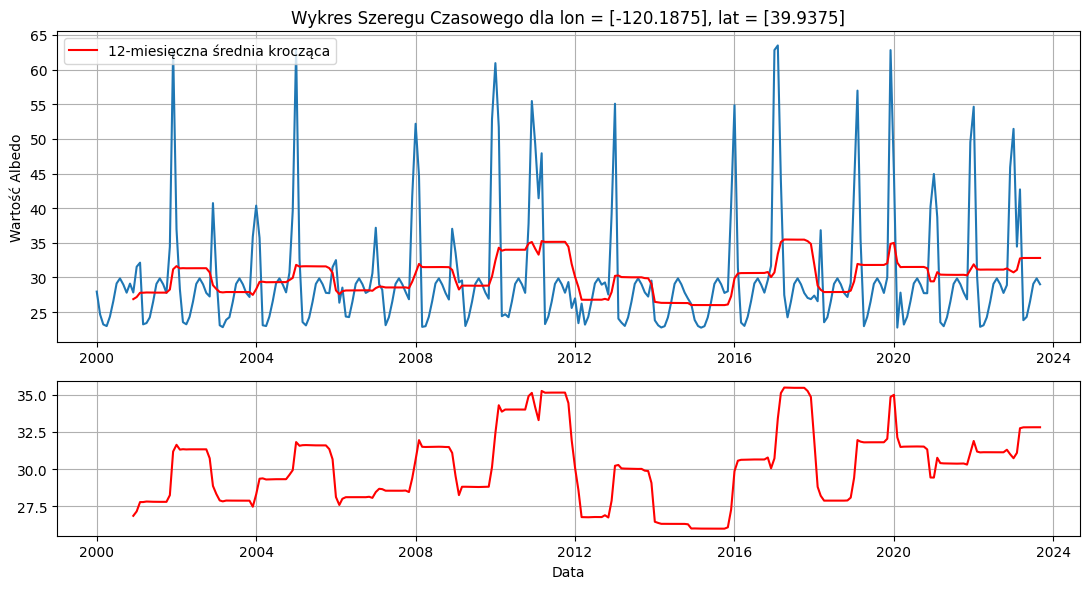

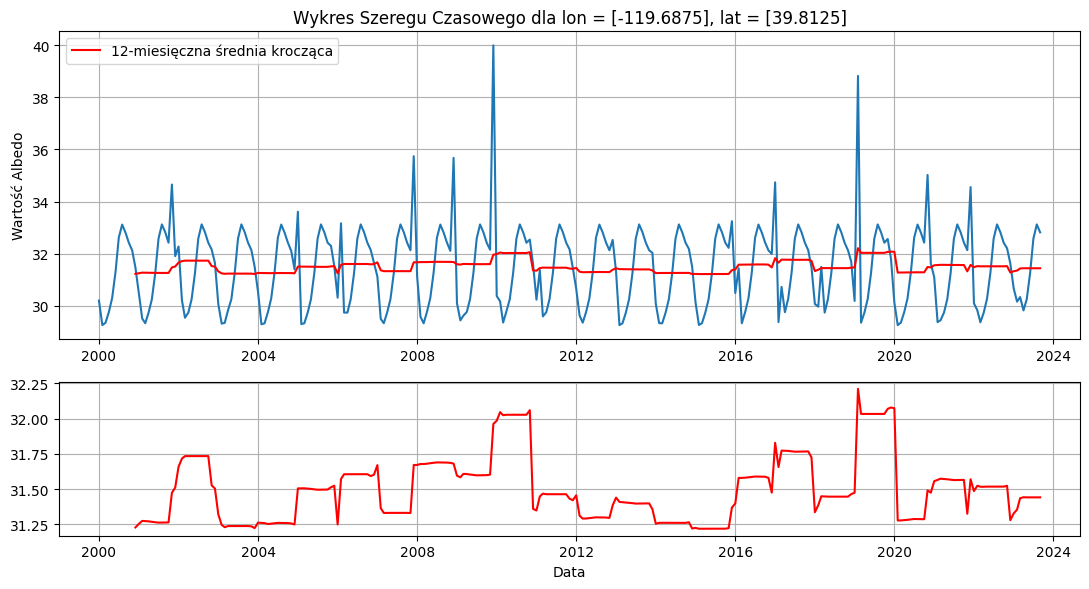

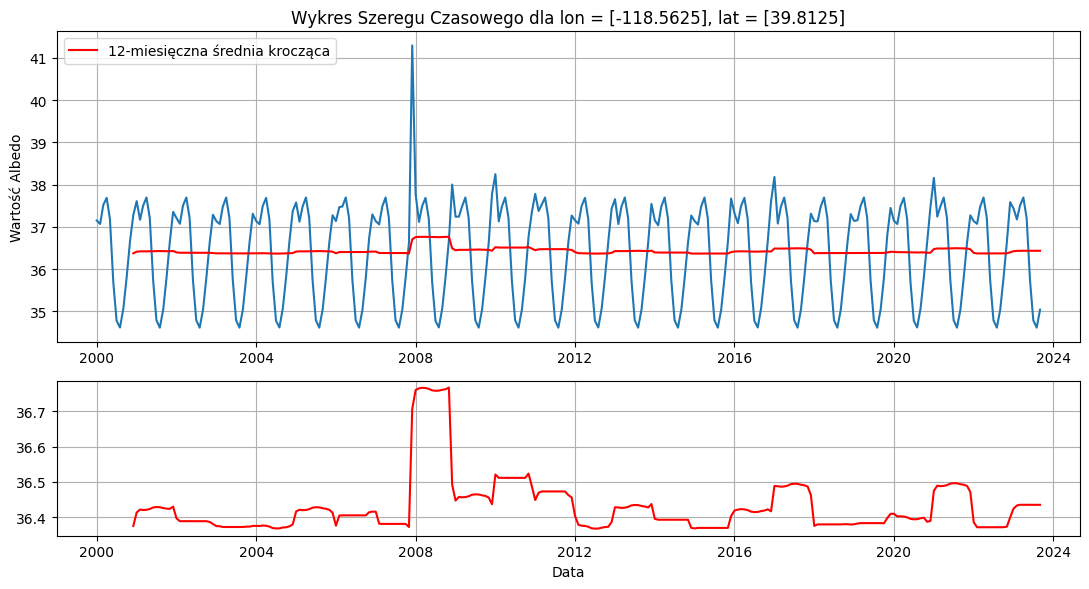

In [47]:
Albedo_time_series_nie_pustynia = extract_time_series_from_dataframe(Albedo_SparkDataFrame, -120.1875, 39.9375)
Albedo_time_series_przejsciowe = extract_time_series_from_dataframe(Albedo_SparkDataFrame, -119.6875, 39.8125)
Albedo_time_series_pustynia = extract_time_series_from_dataframe(Albedo_SparkDataFrame, -118.5625, 39.8125)
plot_time_series(Albedo_time_series_nie_pustynia, 'Albedo')
plot_time_series(Albedo_time_series_przejsciowe, 'Albedo')
plot_time_series(Albedo_time_series_pustynia, 'Albedo')

In [48]:
check_stationarity(Albedo_time_series_pustynia['Albedo'])

ADF Statistic: -3.580464
p-value: 0.006146
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Stationary


In [49]:
check_stationarity(Albedo_time_series_przejsciowe['Albedo'])

ADF Statistic: -3.862542
p-value: 0.002328
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Stationary


In [50]:
check_stationarity(Albedo_time_series_nie_pustynia['Albedo'])

ADF Statistic: -3.824036
p-value: 0.002671
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Stationary


## **SoilM_40_100cm** (wskaźnik zawartości wody w warstwie o głębokości od 40 do 100 cm)

In [54]:
#Pomiaru zawsze na 1 dzień miesiąca.
SoilM_40_100cm_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, SoilM_40_100cm
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

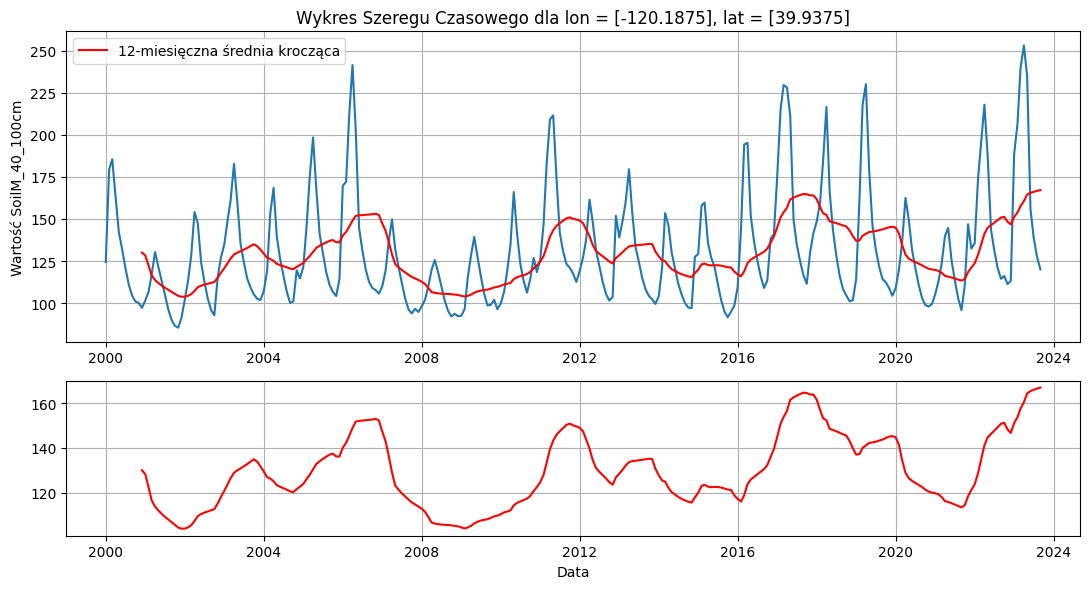

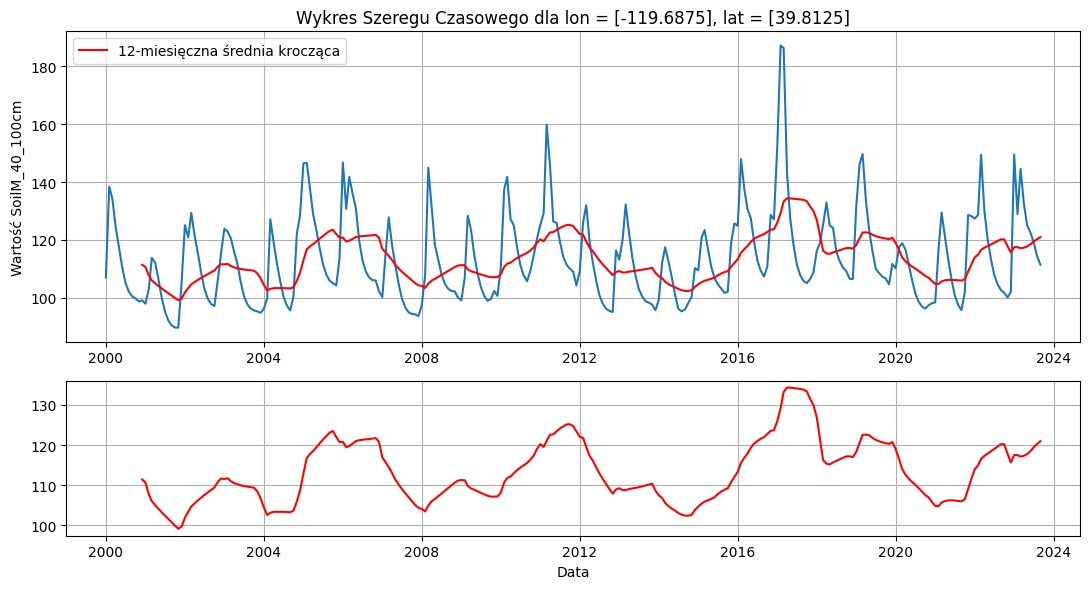

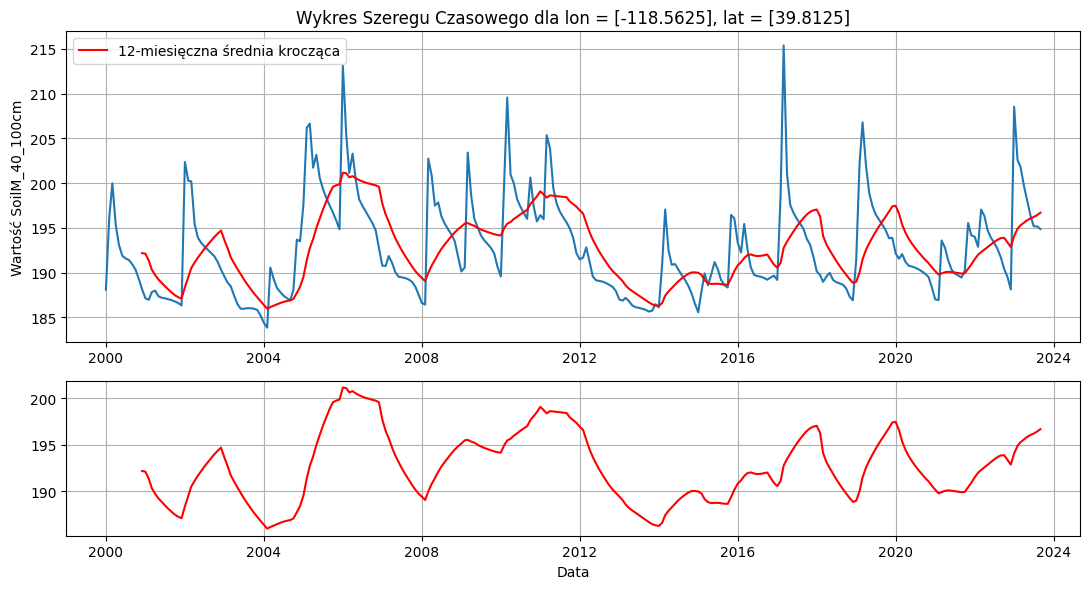

In [55]:
SoilM_40_100cm_time_series_nie_pustynia = extract_time_series_from_dataframe(SoilM_40_100cm_SparkDataFrame, -120.1875, 39.9375)
SoilM_40_100cm_time_series_przejsciowe = extract_time_series_from_dataframe(SoilM_40_100cm_SparkDataFrame, -119.6875, 39.8125)
SoilM_40_100cm_time_series_pustynia = extract_time_series_from_dataframe(SoilM_40_100cm_SparkDataFrame, -118.5625, 39.8125)
plot_time_series(SoilM_40_100cm_time_series_nie_pustynia, 'SoilM_40_100cm')
plot_time_series(SoilM_40_100cm_time_series_przejsciowe, 'SoilM_40_100cm')
plot_time_series(SoilM_40_100cm_time_series_pustynia, 'SoilM_40_100cm')

In [56]:
check_stationarity(SoilM_40_100cm_time_series_pustynia['SoilM_40_100cm'])

ADF Statistic: -5.936323
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572
Stationary


In [57]:
check_stationarity(SoilM_40_100cm_time_series_przejsciowe['SoilM_40_100cm'])

ADF Statistic: -3.562536
p-value: 0.006519
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Stationary


In [58]:
check_stationarity(SoilM_40_100cm_time_series_nie_pustynia['SoilM_40_100cm'])

ADF Statistic: -2.925455
p-value: 0.042467
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Stationary


## **GVEG** (wskaźnik roślinności)

In [59]:
#Pomiaru zawsze na 1 dzień miesiąca.
GVEG_SparkDataFrame = spark.sql("""
                        SELECT
                        lon, lat,
                        to_date(CONCAT(Year, '-', Month, '-1')) as Date, GVEG
                        FROM nasa_ym
                        order by lon, lat, Year, Month
                        """)

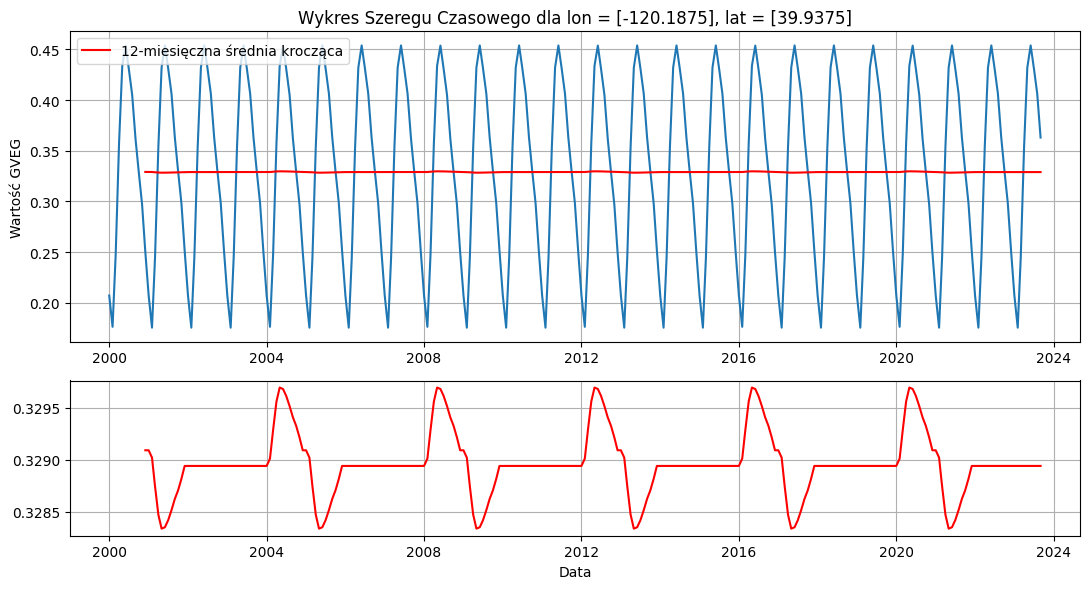

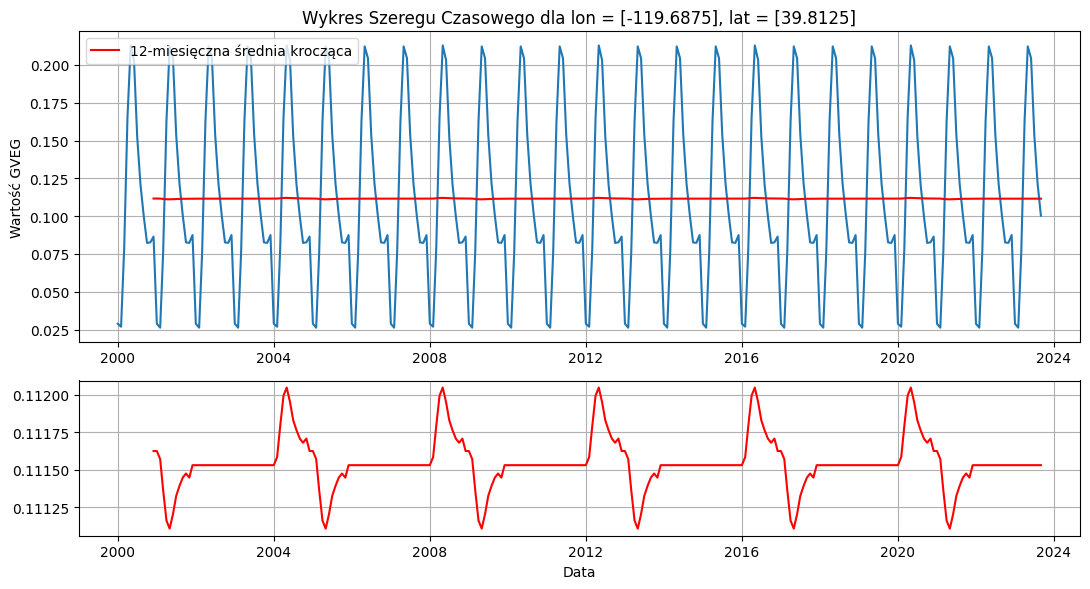

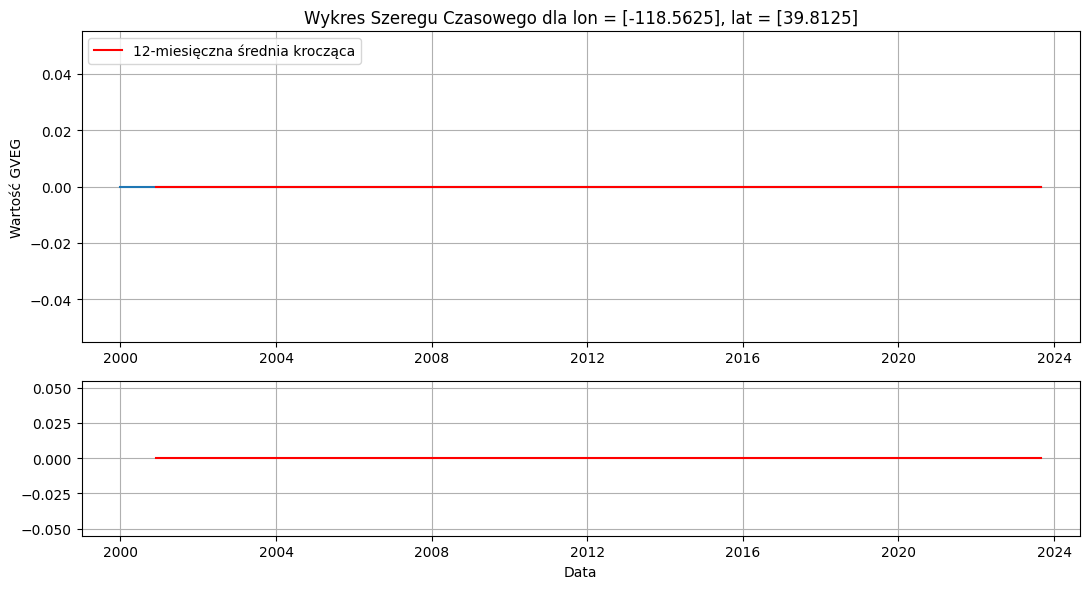

In [60]:
GVEG_time_series_nie_pustynia = extract_time_series_from_dataframe(GVEG_SparkDataFrame, -120.1875, 39.9375)
GVEG_time_series_przejsciowe = extract_time_series_from_dataframe(GVEG_SparkDataFrame, -119.6875, 39.8125)
GVEG_time_series_pustynia = extract_time_series_from_dataframe(GVEG_SparkDataFrame, -118.5625, 39.8125)
plot_time_series(GVEG_time_series_nie_pustynia, 'GVEG')
plot_time_series(GVEG_time_series_przejsciowe, 'GVEG')
plot_time_series(GVEG_time_series_pustynia, 'GVEG')

In [62]:
check_stationarity(GVEG_time_series_przejsciowe['GVEG'])

ADF Statistic: -5.682032
p-value: 0.000001
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Stationary


In [63]:
check_stationarity(GVEG_time_series_nie_pustynia['GVEG'])

ADF Statistic: -6.371652
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Stationary
